In [1]:
!pip install -q efficientnet

In [2]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
os.listdir("/kaggle/input/vegnet-organized-dataset-of-cauliflower-disease")

Using TensorFlow backend.


['Original Dataset']

In [3]:
import os
import gc
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
from IPython.display import SVG
import efficientnet.tfkeras as efn
from keras.utils import plot_model
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.applications import DenseNet121

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)
tf.random.set_seed(0)

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
EPOCHS = 200
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((75,75))
image_size = 0
directory_root = '/kaggle/input/vegnet-organized-dataset-of-cauliflower-disease'
width=75
height=75
depth=3

In [5]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
image_list, label_list, directory_list = [], [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".jpeg") == True:
                    directory_list.append(image_directory)
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
                else:
                    print(image_directory)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error --- : {e}")

[INFO] Loading images ...
[INFO] Processing Downy Mildew ...
[INFO] Processing Black Rot ...
[INFO] Processing Bacterial spot rot ...
[INFO] Processing No disease ...
[INFO] Image loading completed


In [6]:
for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

[INFO] Processing Downy Mildew ...
[INFO] Processing Black Rot ...
[INFO] Processing Bacterial spot rot ...
[INFO] Processing No disease ...


In [7]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['Bacterial spot rot' 'Black Rot' 'Downy Mildew' 'No disease']


In [8]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.1, random_state = 42) 

[INFO] Spliting data to train, test


In [9]:
x_train.shape,x_test.shape

((590, 75, 75, 3), (66, 75, 75, 3))

In [10]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [11]:
import tensorflow as tf
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                     min_delta=0.0001,
                                     patience=10,
                                     mode="auto",
                                     verbose = 1)
]

In [12]:
len(image_list)

656

# **Our Model**

In [13]:
def Res_Plot_Test_Save(name):
    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {scores[1]*100}")
    print("[INFO] Saving model")
    model.save(name)

In [14]:
def display_training_curves(training, validation, yaxis):
    ylabel = "{}".format(yaxis)
    title = "{} vs. Epochs".format(yaxis)
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Train"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Val"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()

In [15]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
# def create_model():
model = tf.keras.backend.clear_session()
model = None
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution

# model.compile(loss="binary_crossentropy", optimizer=opt, metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Accuracy()])
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy', f1_m,  precision_m, recall_m])


In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 75, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 25, 25, 64)       

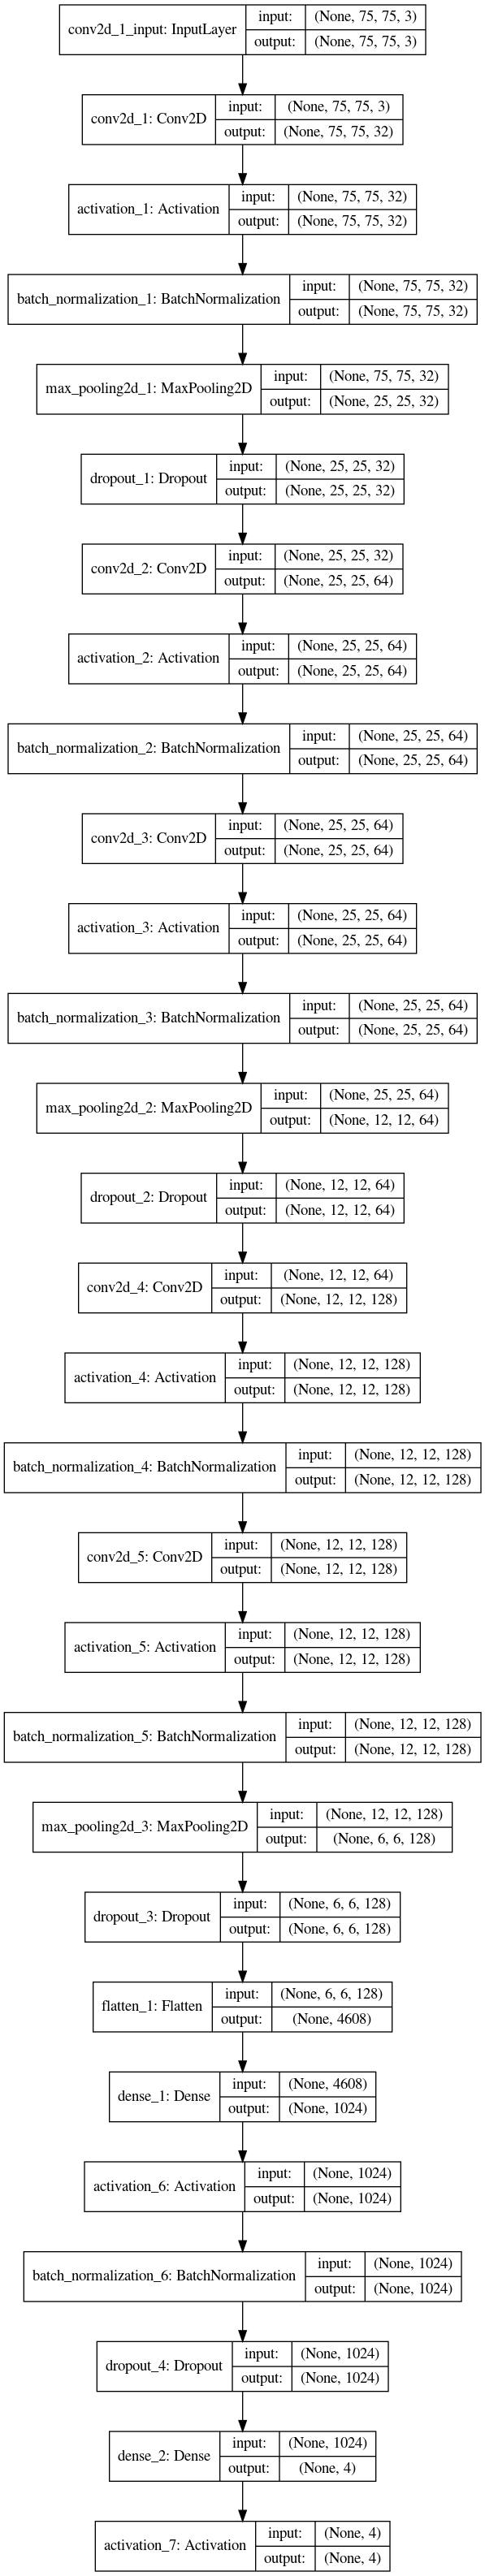

In [18]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
# train the network
print("[INFO] training network...")
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs= 200
    )

[INFO] training network...
Epoch 1/200
18/18 [==============================] - 5s 275ms/step - loss: 0.6918 - accuracy: 0.7666 - f1_m: 0.5166 - precision_m: 0.5340 - recall_m: 0.5005 - val_loss: 0.5495 - val_accuracy: 0.7500 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/200
18/18 [==============================] - 1s 48ms/step - loss: 0.3732 - accuracy: 0.8539 - f1_m: 0.7055 - precision_m: 0.7190 - recall_m: 0.6930 - val_loss: 0.6961 - val_accuracy: 0.6742 - val_f1_m: 0.1505 - val_precision_m: 0.1894 - val_recall_m: 0.1250
Epoch 3/200
18/18 [==============================] - 1s 46ms/step - loss: 0.3639 - accuracy: 0.8763 - f1_m: 0.7485 - precision_m: 0.7582 - recall_m: 0.7393 - val_loss: 0.6518 - val_accuracy: 0.7273 - val_f1_m: 0.3148 - val_precision_m: 0.4231 - val_recall_m: 0.2708
Epoch 4/200
18/18 [==============================] - 1s 50ms/step - loss: 0.3259 - accuracy: 0.8956 - f1_m: 0.7824 - precision_m: 0.8052 - recall_m: 0.7614 - val_

In [20]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: {} \nLoss:{} \nF1_score: {} \nPrecision: {} \nRecall: {}".format(accuracy, loss, f1_score, precision, recall))

Accuracy: 0.9696969985961914 
Loss:0.18054932175260602 
F1_score: 0.9583333134651184 
Precision: 0.9583333134651184 
Recall: 0.9583333134651184


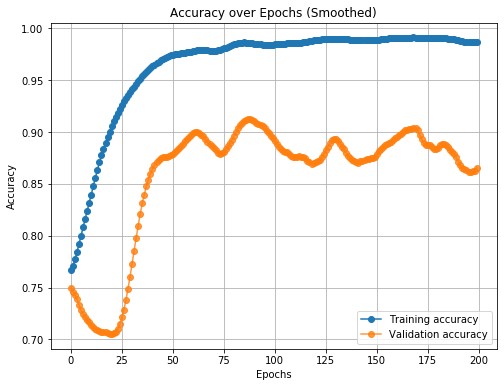

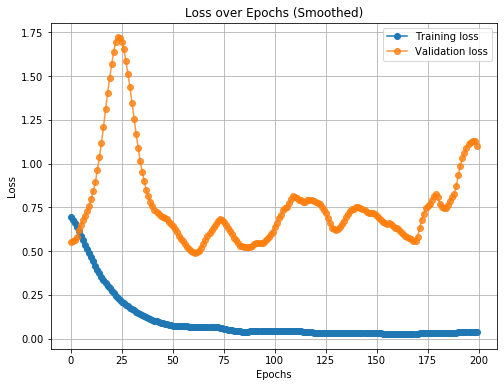

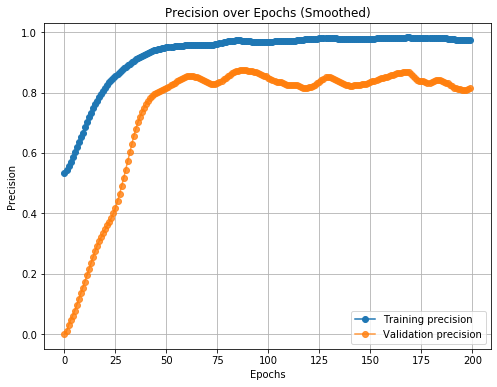

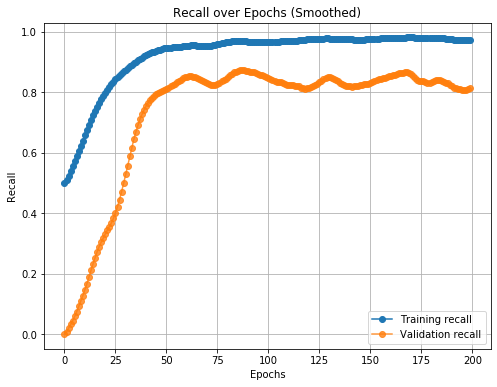

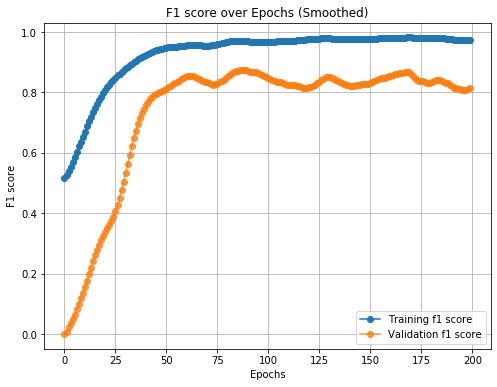

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def smooth_data(data, window_size=10, smoothing_factor=0.8):
    """
    Smooths the input data using a combination of moving average and exponential smoothing.
    
    Args:
    - data (list): The data to be smoothed.
    - window_size (int): The size of the moving average window.
    - smoothing_factor (float): The factor for exponential smoothing.
    
    Returns:
    - list: Smoothed data.
    """
    # Moving Average Smoothing
    moving_avg = []
    for i in range(len(data)):
        start = max(0, i - window_size + 1)
        end = i + 1
        moving_avg.append(np.mean(data[start:end]))
    
    # Exponential Smoothing
    exp_smooth = []
    last = moving_avg[0]
    for point in moving_avg:
        smoothed_val = last * smoothing_factor + point * (1 - smoothing_factor)
        exp_smooth.append(smoothed_val)
        last = smoothed_val
    
    return exp_smooth

def display_training_curves(training, validation, metric, window_size=10, smoothing_factor=0.8):
    """
    Plots the training and validation curves for a given metric with dual smoothing applied.
    
    Args:
    - training (list): Training data for the metric.
    - validation (list): Validation data for the metric.
    - metric (str): Name of the metric (e.g., 'accuracy', 'loss').
    - window_size (int): The window size for moving average.
    - smoothing_factor (float): The smoothing factor for exponential smoothing.
    """
    training_smoothed = smooth_data(training, window_size, smoothing_factor)
    validation_smoothed = smooth_data(validation, window_size, smoothing_factor)

    plt.figure(figsize=(8, 6))
    plt.plot(training_smoothed, label=f'Training {metric}', marker='o')
    plt.plot(validation_smoothed, label=f'Validation {metric}', marker='o', alpha=0.8)
    plt.title(f'{metric.capitalize()} over Epochs (Smoothed)')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Example Usage with history object
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy',
    window_size=10,  # Larger window for smoother data
    smoothing_factor=0.9  # Aggressive exponential smoothing
)
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss',
    window_size=10,
    smoothing_factor=0.9
)
display_training_curves(
    history.history['precision_m'], 
    history.history['val_precision_m'], 
    'precision',
    window_size=10,
    smoothing_factor=0.9
)
display_training_curves(
    history.history['recall_m'], 
    history.history['val_recall_m'], 
    'recall',
    window_size=10,
    smoothing_factor=0.9
)
display_training_curves(
    history.history['f1_m'], 
    history.history['val_f1_m'], 
    'f1 score',
    window_size=10,
    smoothing_factor=0.9
)

## Predicting on a single image

/kaggle/input/vegnet-organized-dataset-of-cauliflower-disease/Original Dataset/Downy Mildew/Downy Mildew. (10).jpeg


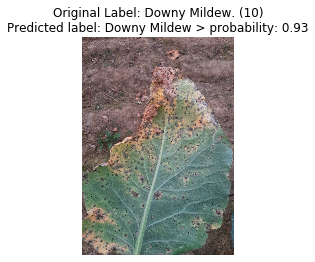

In [27]:
from random import randint

image_dir= "/kaggle/input/vegnet-organized-dataset-of-cauliflower-disease/Original Dataset/Downy Mildew/Downy Mildew. (10).jpeg"
print(image_dir)
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image1 = plt.imread(image_dir)

im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
# print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
plt.show()

## Predicting on four random images

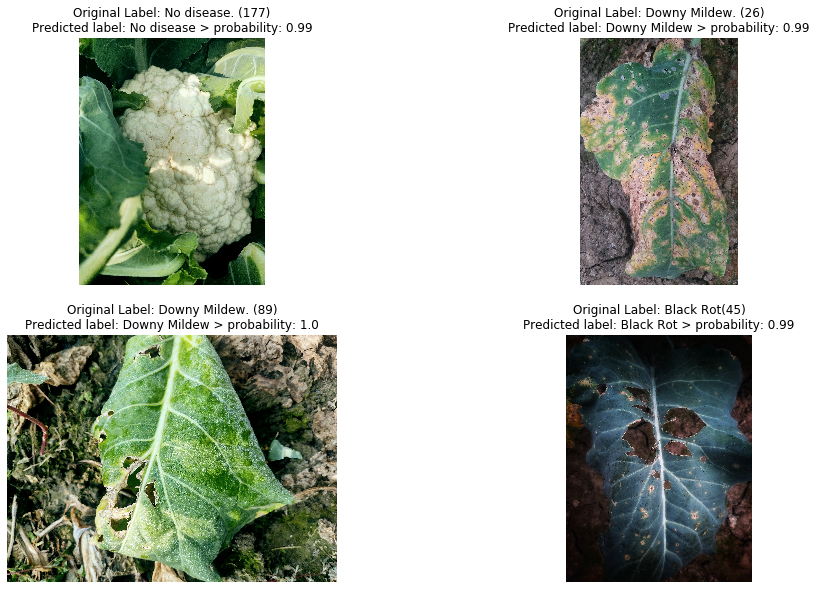

In [45]:
# create figure
fig = plt.figure(figsize=(16, 10))
  
# setting values to rows and column variables
rows = 2
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
image_dir=directory_list[randint(0,len(directory_list))]
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image1 = plt.imread(image_dir)
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
plt.imshow(Image1)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
image_dir=directory_list[randint(0,len(directory_list))]
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image2 = plt.imread(image_dir)
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
plt.imshow(Image2)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
image_dir=directory_list[randint(0,len(directory_list))]
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image3 = plt.imread(image_dir)
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
plt.imshow(Image3)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
image_dir=directory_list[randint(0,len(directory_list))]
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image4 = plt.imread(image_dir)
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
plt.imshow(Image4)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
plt.show()

# Confusion Matrix

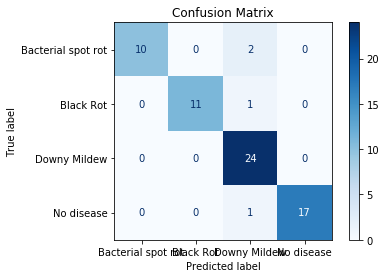

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_binarizer.classes_)
cmd.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


# Class Distribution in Predictions

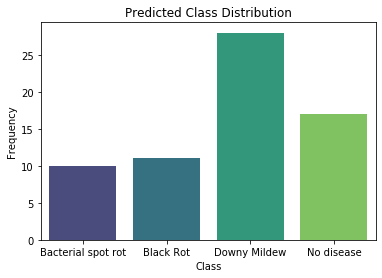

In [37]:
import seaborn as sns

sns.countplot(x=y_pred_classes, palette="viridis")
plt.title("Predicted Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(ticks=range(n_classes), labels=label_binarizer.classes_)
plt.show()


# Metric Aggregation

In [39]:
# Per-class metrics
from sklearn.metrics import classification_report

report = classification_report(y_true_classes, y_pred_classes, target_names=label_binarizer.classes_)
print(report)


                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.83      0.91        12
         Black Rot       1.00      0.92      0.96        12
      Downy Mildew       0.86      1.00      0.92        24
        No disease       1.00      0.94      0.97        18

          accuracy                           0.94        66
         macro avg       0.96      0.92      0.94        66
      weighted avg       0.95      0.94      0.94        66



# Model Size and Speed

In [40]:
import time

# Model size
model.save("model.h5")
model_size = os.path.getsize("model.h5") / (1024 * 1024)
print(f"Model Size: {model_size:.2f} MB")

# Inference time
start_time = time.time()
_ = model.predict(np.expand_dims(x_test[0], axis=0))
end_time = time.time()
print(f"Inference Time per Image: {end_time - start_time:.5f} seconds")


Model Size: 57.38 MB
Inference Time per Image: 0.00784 seconds


# ROC-AUC Curve

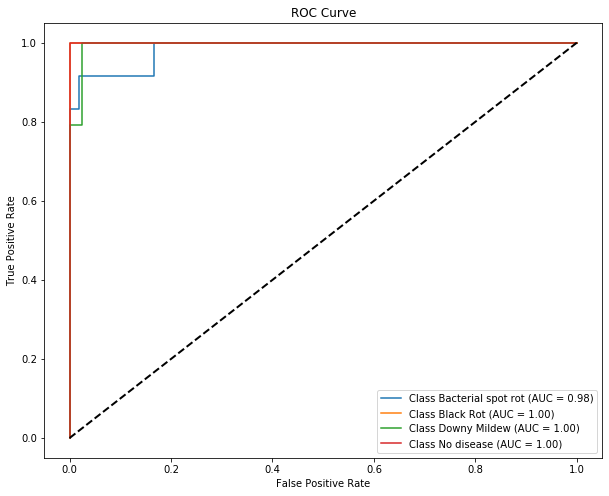

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize y_test for multi-class ROC-AUC
y_test_binarized = label_binarize(y_true_classes, classes=range(n_classes))

# Calculate ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_binarizer.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


# Precision-Recall Curve


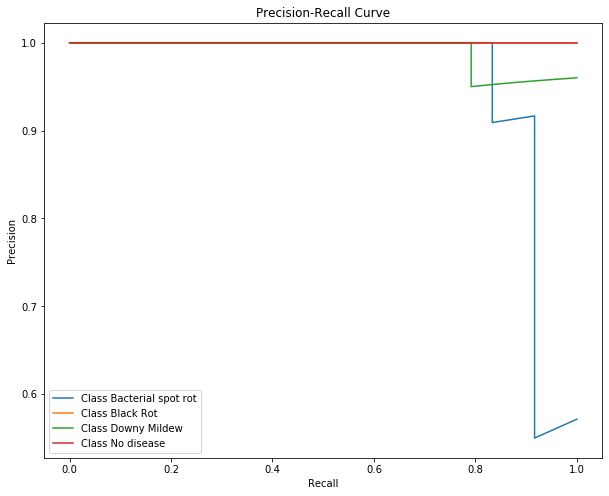

In [42]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred[:, i])
    plt.plot(recall, precision, label=f'Class {label_binarizer.classes_[i]}')

plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()
